# Apriori vs Word2Vec Model Comparison

This notebook compares the performance of Apriori and Word2Vec models for detecting complementary products in market basket analysis. The comparison includes:

- Execution time and memory usage
- Coverage and cross-category complimentarity metrics
- Execution time and Memory usage
- Visualization of key metrics

The `ModelEvaluator` class handles the evaluation process, including model training, metric calculation, and visualization.

## Libraries

In [17]:
import pandas as pd
import os
import time
import tracemalloc
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')

## Configuration and Parameters

In [18]:

# File path settings

current_dir = os.getcwd() 
project_root = os.path.dirname(current_dir)  
path = os.path.join(project_root, "Dataset")
path_results = os.path.join(project_root, "Results")
excel_file = 'full_validated_dataset.xlsx'

# Apriori parameters
apriori_min_support = 0.01
apriori_min_confidence = 0.05
apriori_min_lift = 1.2

# Word2Vec parameters
vector_size_num = 100
window_num = 5
workers_num = 4
negative_sampling = 10
epoches_num = 10
min_count = 2
w2v_min_count = 2
w2v_topn = 10


## ModelEvaluator Class Definition

In [19]:

class ModelEvaluator:
    """
    Class to evaluate and compare Apriori and Word2Vec models across multiple metrics.
    """
    
    def __init__(self, data_path, path_results, excel_file, data_subset=None, subset_name="whole"):
        """
        Initialize with dataset path and optional data subset.
        
        Args:
            data_path (str): Path to the data directory
            path_results (str): Path to save results
            excel_file (str): Name of the Excel file containing transaction data
            data_subset (DataFrame, optional): Subset of data to use instead of loading from file
            subset_name (str): Name of the data subset (e.g., "whole", "first_third", "last_two_thirds")
        """
        self.data_path = data_path
        self.path_results = path_results
        self.excel_file = excel_file
        self.file_path = os.path.join(data_path, excel_file)
        self.subset_name = subset_name
        self.metrics = {
            'apriori': {},
            'word2vec': {}
        }
        
        if data_subset is not None:
            self.data_excel = data_subset.copy()
        else:
            self.data_excel = pd.read_excel(self.file_path)
        
        self.data_excel.dropna(subset=['Itemname'], inplace=True)
        
        self.basket = self.data_excel.groupby('BillNo')['Itemname'].apply(list)
        self.transactions = self.basket.values.tolist()
        self.unique_products = self.data_excel['Itemname'].unique().tolist()
    
        self.product_to_category = {}
        if 'category' in self.data_excel.columns:
            
            product_category_mapping = self.data_excel[['Itemname', 'category']].drop_duplicates()
            self.product_to_category = dict(zip(product_category_mapping['Itemname'], product_category_mapping['category']))
        
      
        self.apriori_rules = None
        self.word2vec_complementary = None
        
        print(f"Dataset loaded for {subset_name} with {len(self.basket)} transactions and {len(self.unique_products)} unique products")
        
    def run_apriori(self, min_support=apriori_min_support, min_confidence=apriori_min_confidence, min_lift=apriori_min_lift):
        """
        Run Apriori algorithm and measure performance.
        
        Args:
            min_support (float): Minimum support threshold
            min_confidence (float): Minimum confidence threshold
            min_lift (float): Minimum lift threshold
            
        Returns:
            dict: Performance metrics for Apriori
        """
        print(f"Running Apriori algorithm for {self.subset_name}...")
        
       
        te = TransactionEncoder()
        te_ary = te.fit(self.transactions).transform(self.transactions)
        basket_encoded = pd.DataFrame(te_ary, columns=te.columns_)
        
       
        tracemalloc.start()
        start_memory = tracemalloc.get_traced_memory()[1] 
        start_time = time.time()

        print(f"Apriori started with {start_memory} bytes memory used")

      
        frequent_itemsets = apriori(basket_encoded, min_support=min_support, use_colnames=True)

     
        rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)
        rules = rules[rules['confidence'] >= min_confidence]

     
        rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))

       
        end_time = time.time()
        current_memory = tracemalloc.get_traced_memory()[1]
        peak_memory = (current_memory - start_memory) / (1024 * 1024) 
        tracemalloc.stop()
        print(f"Apriori ended with {peak_memory} MB memory used")
        
        self.apriori_rules = rules
        
       
        self.apriori_product_pairs = self.convert_apriori_rules_to_pairs(rules)
        
        # Store metrics
        self.metrics['apriori'] = {
            'execution_time': end_time - start_time,
            'memory_usage': peak_memory,
            'num_rules': len(rules),
            'coverage': self.calculate_apriori_coverage(rules),
           
        }
        
        print(f"Apriori completed for {self.subset_name} with {len(rules)} rules generated")
        return self.metrics['apriori']
    
    def convert_apriori_rules_to_pairs(self, apriori_rules):
        """
        Convert Apriori rules to a consistent product pairs table with category information.
        
        Args:
            apriori_rules (DataFrame): DataFrame containing Apriori rules
            
        Returns:
            DataFrame: Consistent format with one product pair per row and category information
        """
        product_pairs = []
        
        for _, rule in apriori_rules.iterrows():
          
            antecedents = list(rule['antecedents'])
            consequents = list(rule['consequents'])
            
       
            for antecedent in antecedents:
                for consequent in consequents:
                 
                    if antecedent == consequent:
                        continue
           
                    pair = {
                        'Original Product': antecedent,
                        'Complementary Product': consequent,
                        'Confidence': rule['confidence'],
                        'Lift': rule['lift'],
                        'Support': rule['support']
                    }
                    
                    if self.product_to_category:
                        if antecedent in self.product_to_category:
                            pair['Original Product category'] = self.product_to_category[antecedent]
                        else:
                            pair['Original Product category'] = 'Unknown'
                            
                        if consequent in self.product_to_category:
                            pair['Complementary Product category'] = self.product_to_category[consequent]
                        else:
                            pair['Complementary Product category'] = 'Unknown'
                    
                    product_pairs.append(pair)
        
        return pd.DataFrame(product_pairs)

    def run_word2vec(self, vector_size=vector_size_num, window=window_num, min_count=min_count, topn=w2v_topn):
        """
        Run Word2Vec model and measure performance.
        
        Args:
            vector_size (int): Dimensionality of word vectors
            window (int): Context window size
            min_count (int): Minimum word frequency
            topn (int): Number of top complementary products to generate
            
        Returns:
            dict: Performance metrics for Word2Vec
        """
        print(f"Running Word2Vec model for {self.subset_name}...")
        
   
        tracemalloc.start()
        start_memory = tracemalloc.get_traced_memory()[1] 
        start_time = time.time()

        print(f"Word2Vec started with {start_memory} bytes memory used")

        model = Word2Vec(
            sentences=self.transactions,
            vector_size=vector_size_num,
            window=window_num,
            sg=1,  
            negative=negative_sampling, 
            min_count=min_count,
            workers=workers_num,
            epochs=epoches_num
        )
        
       
        comprehensive_results = []
        
        model_vocab = set(model.wv.index_to_key)
        
        for product in self.unique_products:
            if product in model_vocab:
                try:
                    similar_products = model.wv.most_similar(product, topn=topn)
                    
                    complementary_list = [
                        {
                            'Original Product': product,
                            'Complementary Product': comp_product,
                            'Similarity Score': similarity,
                            'Rank': rank + 1
                        }
                        for rank, (comp_product, similarity) in enumerate(similar_products)
                    ]
                    
                    comprehensive_results.extend(complementary_list)
                except KeyError:
                    pass
            else:
                pass
        
        complementary_products_df = pd.DataFrame(comprehensive_results)
        
        if self.product_to_category and not complementary_products_df.empty:
            
            complementary_products_df['Original Product category'] = complementary_products_df['Original Product'].apply(
                lambda x: self.product_to_category.get(x, 'Unknown')
            )
     
            complementary_products_df['Complementary Product category'] = complementary_products_df['Complementary Product'].apply(
                lambda x: self.product_to_category.get(x, 'Unknown')
            )
        
   
        end_time = time.time()
        current_memory = tracemalloc.get_traced_memory()[1]
        peak_memory = (current_memory - start_memory) / (1024 * 1024) 
        tracemalloc.stop()
        print(f"Word2Vec ended with {peak_memory} MB memory used")
        
        self.word2vec_complementary = complementary_products_df
        self.word2vec_model = model
        
       
        self.metrics['word2vec'] = {
            'execution_time': end_time - start_time,
            'memory_usage': peak_memory,
            'num_recommendations': len(complementary_products_df),
            'coverage': self.calculate_word2vec_coverage(model, complementary_products_df),
            
        }
        
        print(f"Word2Vec completed for {self.subset_name} with {len(complementary_products_df)} recommendations generated")
        return self.metrics['word2vec']
    
    def calculate_apriori_coverage(self, rules):
        """
        Calculate coverage for Apriori rules.
        
        Args:
            rules (DataFrame): Association rules
            
        Returns:
            float: Coverage score
        """
        unique_antecedents = set()
        unique_consequents = set()
        
        for _, row in rules.iterrows():
            antecedents = set(row['antecedents'])
            consequents = set(row['consequents'])
            
            unique_antecedents.update(antecedents)
            unique_consequents.update(consequents)
        
        unique_items = unique_antecedents.union(unique_consequents)
        coverage = len(unique_items) / len(self.unique_products)
        
        return coverage
    
    def calculate_word2vec_coverage(self, model, complementary_df):
        """
        Calculate coverage for Word2Vec model.
        
        Args:
            model (Word2Vec): Trained Word2Vec model
            complementary_df (DataFrame): Generated complementary products
            
        Returns:
            float: Coverage score
        """
        products_with_embeddings = complementary_df['Original Product'].nunique()
        coverage = products_with_embeddings / len(self.unique_products)
        
        return coverage
    
   
    
    
    def analyze_category_relationships(self):
        """
        Analyze the Cross-Category Complementarity.
        
        Returns:
            dict: Analysis results for both methods
        """
        results = {'apriori': {}, 'word2vec': {}}
        
    
        if self.product_to_category and self.apriori_product_pairs is not None and self.word2vec_complementary is not None:
            
            if 'Original Product category' in self.apriori_product_pairs.columns:
               
                category_combinations = self.apriori_product_pairs.groupby(
                    ['Original Product category', 'Complementary Product category']
                ).size().reset_index(name='frequency')
                
          
                category_combinations = category_combinations.sort_values('frequency', ascending=False)
                
                
                same_category = self.apriori_product_pairs[
                    self.apriori_product_pairs['Original Product category'] == 
                    self.apriori_product_pairs['Complementary Product category']
                ]
                same_category_percentage = len(same_category) / len(self.apriori_product_pairs) * 100
                
                results['apriori'] = {
                    'top_category_combinations': category_combinations.head(10),
                    'same_category_percentage': same_category_percentage,
                    'cross_category_percentage': 100 - same_category_percentage
                }
            
     
            if 'Original Product category' in self.word2vec_complementary.columns:
               
                category_combinations = self.word2vec_complementary.groupby(
                    ['Original Product category', 'Complementary Product category']
                ).size().reset_index(name='frequency')
                
              
                category_combinations = category_combinations.sort_values('frequency', ascending=False)
                
               
                same_category = self.word2vec_complementary[
                    self.word2vec_complementary['Original Product category'] == 
                    self.word2vec_complementary['Complementary Product category']
                ]
                same_category_percentage = len(same_category) / len(self.word2vec_complementary) * 100
                
                results['word2vec'] = {
                    'top_category_combinations': category_combinations.head(10),
                    'same_category_percentage': same_category_percentage,
                    'cross_category_percentage': 100 - same_category_percentage
                }
        
        return results
    
    def compare_models(self):
        """
        Compare performance metrics between Apriori and Word2Vec.
        
        Returns:
            DataFrame: Comparison of metrics
        """
     
        if not self.metrics['apriori'] or not self.metrics['word2vec']:
            print("Both models need to be run before comparison")
            return
        
      
        comparison = pd.DataFrame({
            'Metric': [
                'Execution Time (s)',
                'Memory Usage (MB)',
                'Number of Rules/Recommendations',
                'Coverage',
            
            ],
            'Apriori': [
                self.metrics['apriori']['execution_time'],
                self.metrics['apriori']['memory_usage'],
                self.metrics['apriori']['num_rules'],
                self.metrics['apriori']['coverage'],
               
            ],
            'Word2Vec': [
                self.metrics['word2vec']['execution_time'],
                self.metrics['word2vec']['memory_usage'],
                self.metrics['word2vec']['num_recommendations'],
                self.metrics['word2vec']['coverage'],
             
            ]
        })
        
        return comparison
    
    def visualize_comparison(self, save_path=None):
        """
        Visualize comparison metrics between Apriori and Word2Vec.
        
        Args:
            save_path (str, optional): Path to save the visualization
        """
        comparison = self.compare_models()
        
    
        metrics_to_plot = ['Execution Time (s)', 'Memory Usage (MB)', 'Coverage']
     
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, metric in enumerate(metrics_to_plot):
            data = comparison[comparison['Metric'] == metric]
            values = data.iloc[0, 1:].astype(float)
            
    
            ax = axes[i]
            sns.barplot(x=['Apriori', 'Word2Vec'], y=values, ax=ax, palette='viridis')
            ax.set_title(f"{self.subset_name} - {metric}", fontsize=14)
            ax.set_ylabel('Value', fontsize=12)
            ax.set_xlabel('')
            
         
            for j, v in enumerate(values):
                ax.text(j, v, f'{v:.4f}', ha='center', va='bottom', fontsize=12)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def visualize_category_relationships(self, save_path=None):
        """
        Visualize category relationships for both methods.
        
        Args:
            save_path (str, optional): Path to save the visualization
        """
        
        category_analysis = self.analyze_category_relationships()
        
        if not category_analysis['apriori'] or not category_analysis['word2vec']:
            print("Category analysis is not available. Make sure models have been run and category information exists.")
            return
        
 
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
        
    
        axes[0].bar(['Same category', 'Cross category'], 
                 [category_analysis['apriori']['same_category_percentage'], 
                  category_analysis['apriori']['cross_category_percentage']])
        axes[0].set_title(f'{self.subset_name} - Apriori: Category Relationships', fontsize=14)
        axes[0].set_ylabel('Percentage (%)', fontsize=12)
        
     
        for i, v in enumerate([category_analysis['apriori']['same_category_percentage'], 
                               category_analysis['apriori']['cross_category_percentage']]):
            axes[0].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=12)
        
      
        axes[1].bar(['Same category', 'Cross category'], 
                 [category_analysis['word2vec']['same_category_percentage'], 
                  category_analysis['word2vec']['cross_category_percentage']])
        axes[1].set_title(f'{self.subset_name} - Word2Vec: Category Relationships', fontsize=14)
        axes[1].set_ylabel('Percentage (%)', fontsize=12)
        
    
        for i, v in enumerate([category_analysis['word2vec']['same_category_percentage'], 
                               category_analysis['word2vec']['cross_category_percentage']]):
            axes[1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=12)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def save_results(self, output_dir=None):
        """
        Save evaluation results to files.
        
        Args:
            output_dir (str, optional): Directory to save results
        """
        if output_dir is None:
            output_dir = self.path_results
            
    
        subset_dir = os.path.join(output_dir, self.subset_name)
        os.makedirs(subset_dir, exist_ok=True)
        
      
        comparison = self.compare_models()
        comparison.to_csv(os.path.join(subset_dir, f'{self.subset_name}_model_comparison_metrics.csv'), index=False)
        
    
        if self.apriori_rules is not None:
            self.apriori_rules.to_excel(os.path.join(subset_dir, f'{self.subset_name}_apriori_rules.xlsx'), index=False)
   
        if hasattr(self, 'apriori_product_pairs') and self.apriori_product_pairs is not None:
            self.apriori_product_pairs.to_excel(os.path.join(subset_dir, f'{self.subset_name}_apriori_product_pairs_with_categories.xlsx'), index=False)
        

        if self.word2vec_complementary is not None:
            self.word2vec_complementary.to_excel(os.path.join(subset_dir, f'{self.subset_name}_word2vec_recommendations.xlsx'), index=False)
   
        self.visualize_comparison(save_path=os.path.join(subset_dir, f'{self.subset_name}_metric_comparison.png'))
   
        if hasattr(self, 'product_to_category') and self.product_to_category:
            self.visualize_category_relationships(save_path=os.path.join(subset_dir, f'{self.subset_name}_category_relationships.png'))
            
     
            category_analysis = self.analyze_category_relationships()
    
            if 'top_category_combinations' in category_analysis['apriori']:
                category_analysis['apriori']['top_category_combinations'].to_excel(
                    os.path.join(subset_dir, f'{self.subset_name}_apriori_top_category_combinations.xlsx'), index=False
                )
            

            if 'top_category_combinations' in category_analysis['word2vec']:
                category_analysis['word2vec']['top_category_combinations'].to_excel(
                    os.path.join(subset_dir, f'{self.subset_name}_word2vec_top_category_combinations.xlsx'), index=False
                )
        
        print(f"Results for {self.subset_name} saved to {subset_dir}")

## Initialize the Evaluator

In [20]:
full_data = pd.read_excel(os.path.join(path, excel_file))
    
# ===== DATA PARTITIONING =====

n = len(full_data)
one_third_index = n // 3

df_whole = full_data.copy()
df_first_third = full_data.iloc[:one_third_index]
df_last_two_thirds = full_data.iloc[one_third_index:]

print(f"Full dataset: {len(df_whole)} records")
print(f"First third: {len(df_first_third)} records")
print(f"Last two thirds: {len(df_last_two_thirds)} records")


os.makedirs(path_results, exist_ok=True)



Full dataset: 520609 records
First third: 173536 records
Last two thirds: 347073 records


## Run Algorithms on Data-Portions


===== EVALUATING WHOLE DATASET =====
Dataset loaded for whole_dataset with 20208 transactions and 4185 unique products
Running Apriori algorithm for whole_dataset...
Apriori started with 0 bytes memory used
Apriori ended with 17748.443567276 MB memory used
Apriori completed for whole_dataset with 3004 rules generated
Running Word2Vec model for whole_dataset...
Word2Vec started with 0 bytes memory used
Word2Vec ended with 16.713348388671875 MB memory used
Word2Vec completed for whole_dataset with 38770 recommendations generated


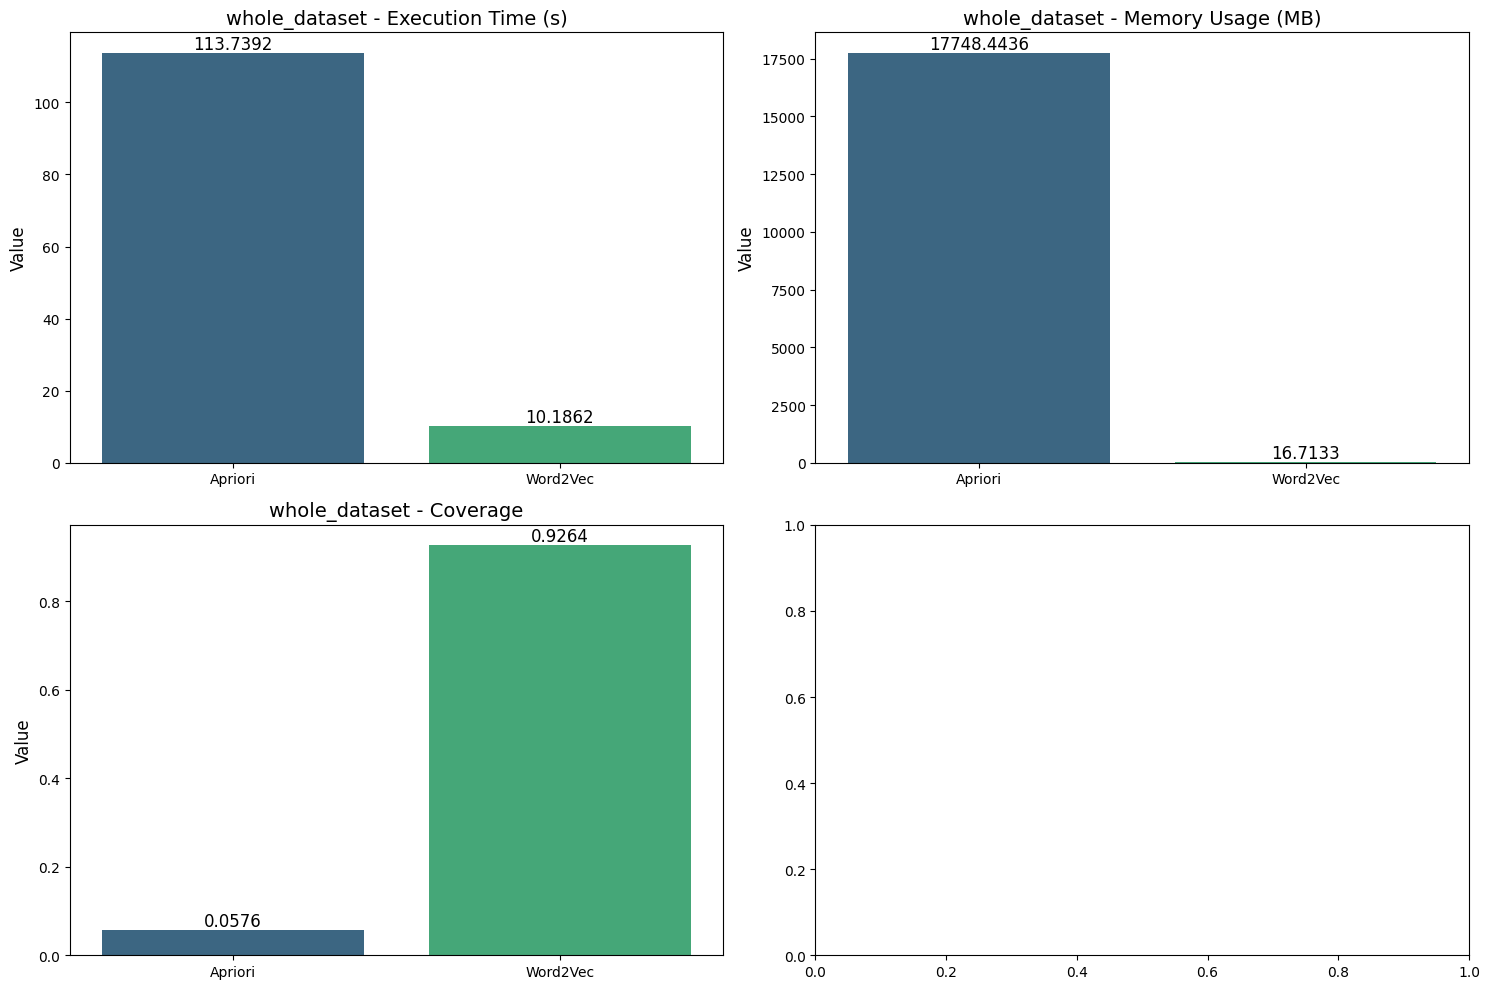

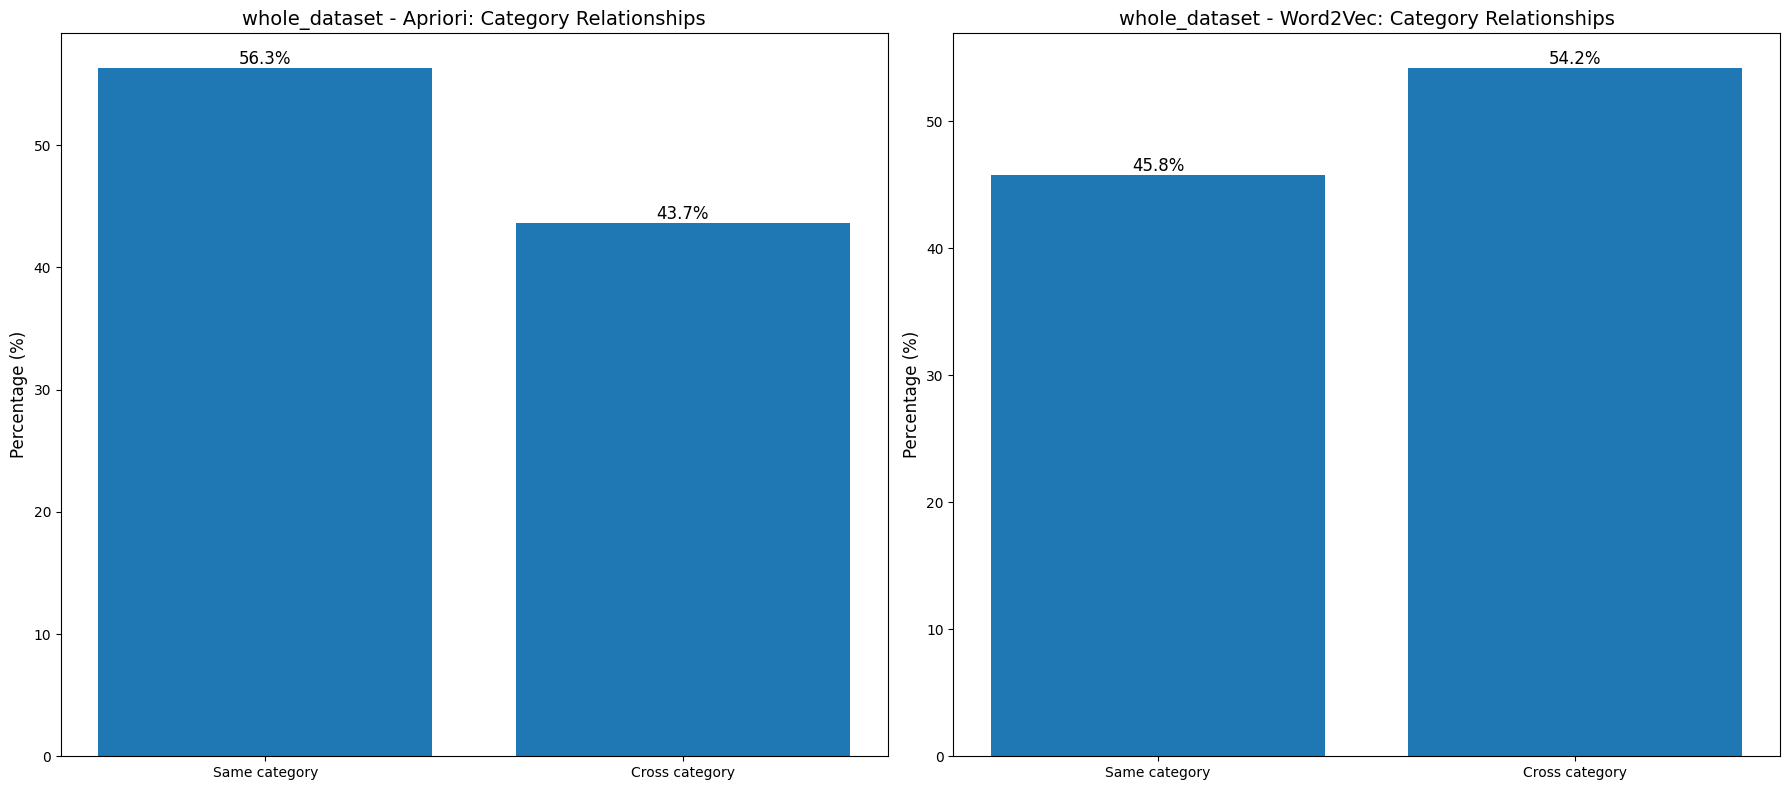

Results for whole_dataset saved to c:\Users\moham\Coding-Projects\Apriori_VS_Word2Vec\Results\whole_dataset

===== EVALUATING FIRST THIRD OF DATASET =====
Dataset loaded for first_third with 6847 transactions and 3326 unique products
Running Apriori algorithm for first_third...
Apriori started with 0 bytes memory used
Apriori ended with 6405.325635910034 MB memory used
Apriori completed for first_third with 4450 rules generated
Running Word2Vec model for first_third...
Word2Vec started with 0 bytes memory used
Word2Vec ended with 13.320441246032715 MB memory used
Word2Vec completed for first_third with 30710 recommendations generated


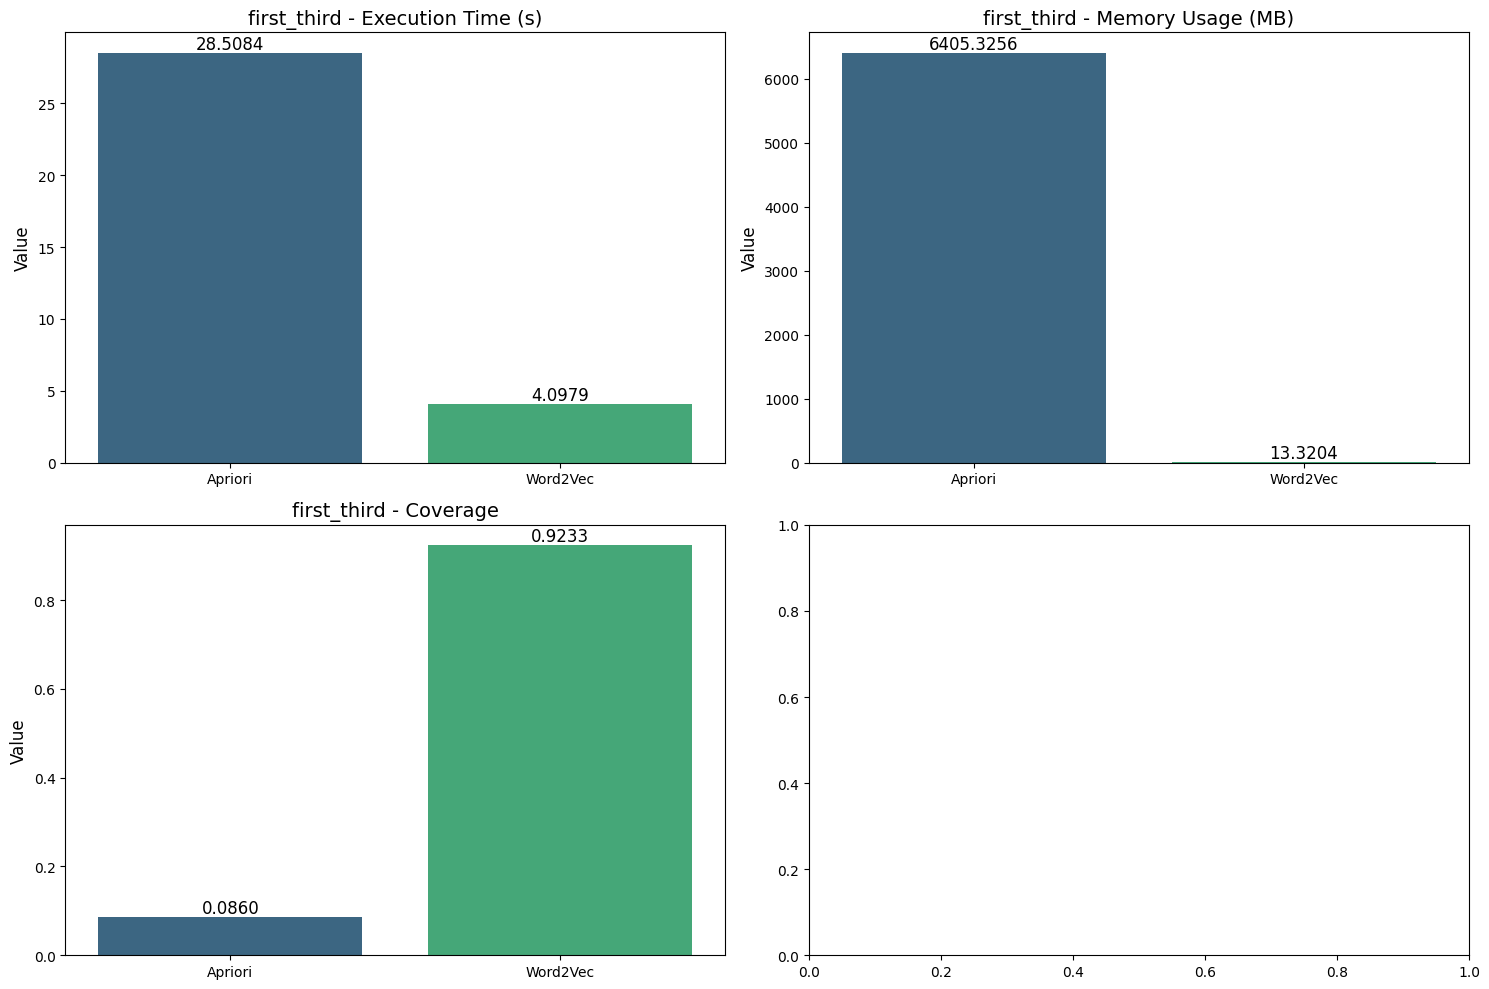

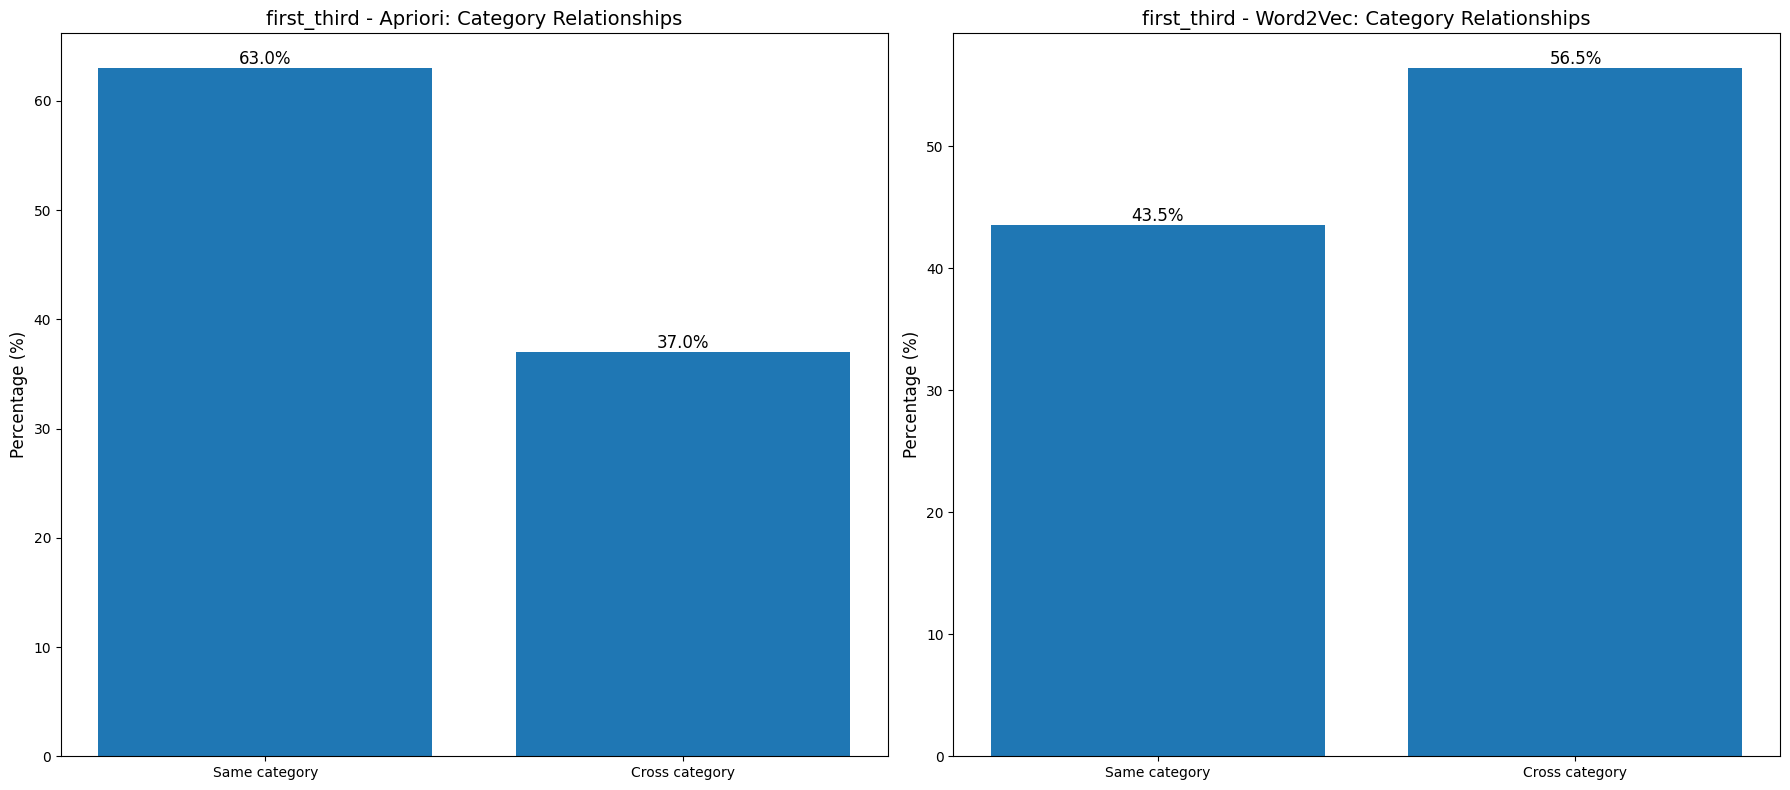

Results for first_third saved to c:\Users\moham\Coding-Projects\Apriori_VS_Word2Vec\Results\first_third

===== EVALUATING LAST TWO THIRDS OF DATASET =====
Dataset loaded for last_two_thirds with 13362 transactions and 3738 unique products
Running Apriori algorithm for last_two_thirds...
Apriori started with 0 bytes memory used
Apriori ended with 12746.004929542542 MB memory used
Apriori completed for last_two_thirds with 6540 rules generated
Running Word2Vec model for last_two_thirds...
Word2Vec started with 0 bytes memory used
Word2Vec ended with 15.050516128540039 MB memory used
Word2Vec completed for last_two_thirds with 34830 recommendations generated


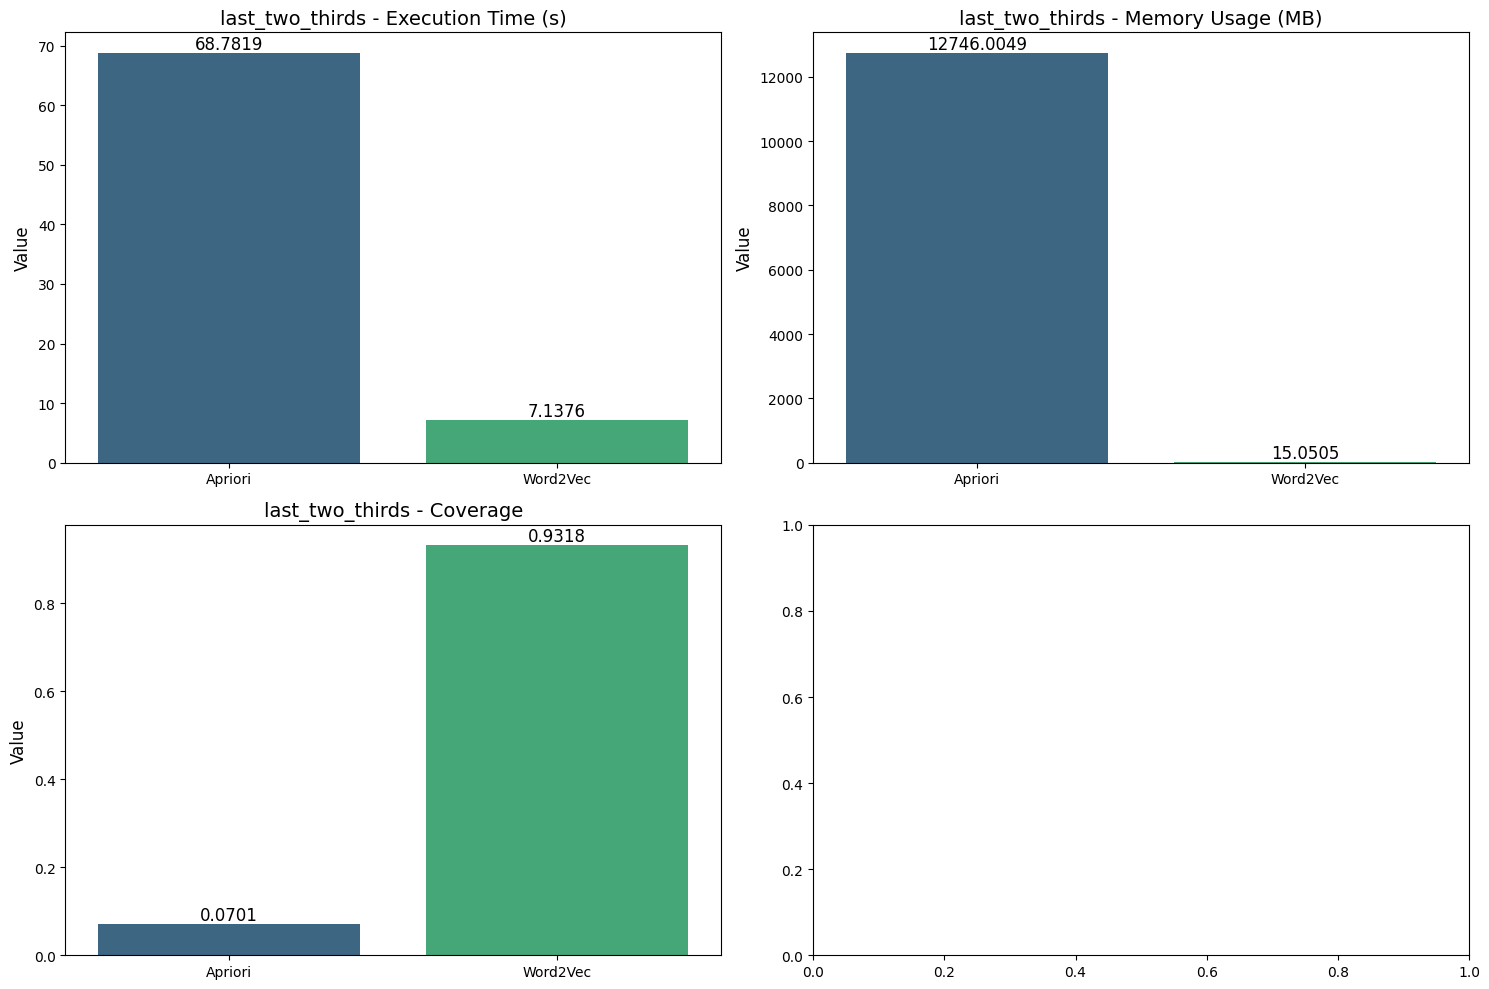

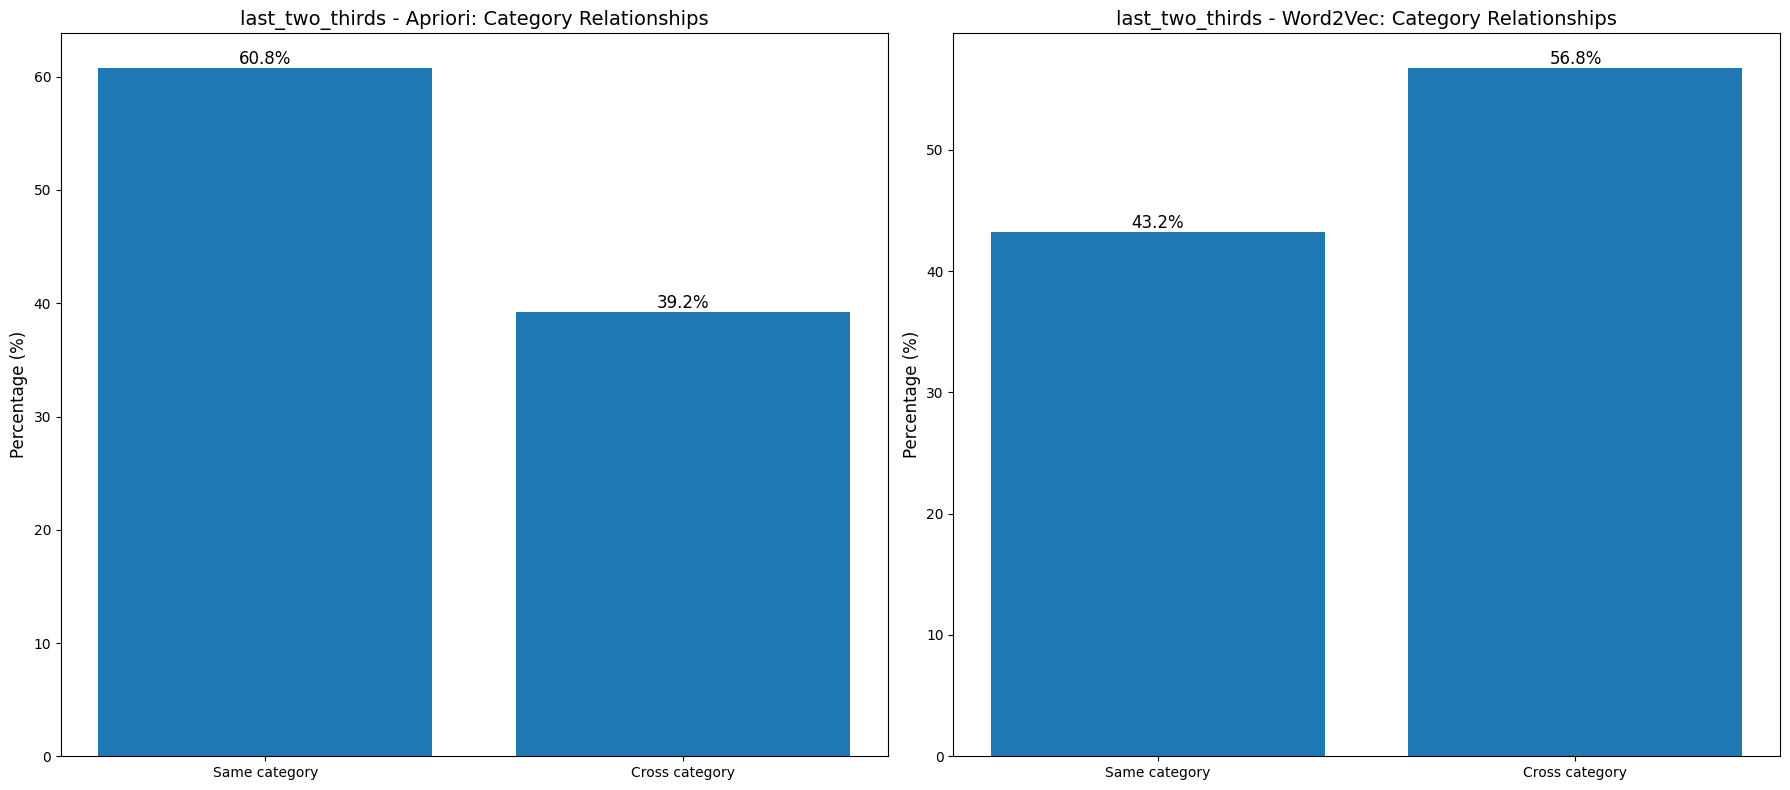

Results for last_two_thirds saved to c:\Users\moham\Coding-Projects\Apriori_VS_Word2Vec\Results\last_two_thirds


In [21]:
print("\n===== EVALUATING WHOLE DATASET =====")
evaluator_whole = ModelEvaluator(path, path_results, excel_file, df_whole, "whole_dataset")
evaluator_whole.run_apriori()
evaluator_whole.run_word2vec()
evaluator_whole.save_results()

# ===== EVALUATE FIRST THIRD =====
print("\n===== EVALUATING FIRST THIRD OF DATASET =====")
evaluator_first_third = ModelEvaluator(path, path_results, excel_file, df_first_third, "first_third")
evaluator_first_third.run_apriori()
evaluator_first_third.run_word2vec()
evaluator_first_third.save_results()

# ===== EVALUATE LAST TWO THIRDS =====
print("\n===== EVALUATING LAST TWO THIRDS OF DATASET =====")
evaluator_last_two_thirds = ModelEvaluator(path, path_results, excel_file, df_last_two_thirds, "last_two_thirds")
evaluator_last_two_thirds.run_apriori()
evaluator_last_two_thirds.run_word2vec()
evaluator_last_two_thirds.save_results()

## Compare Models

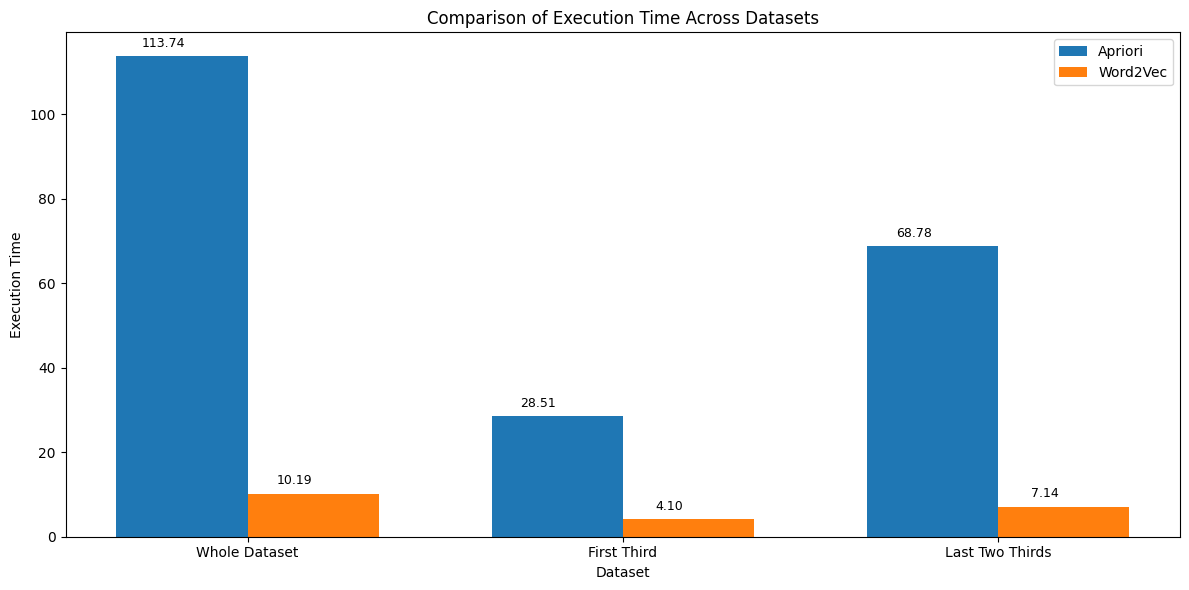

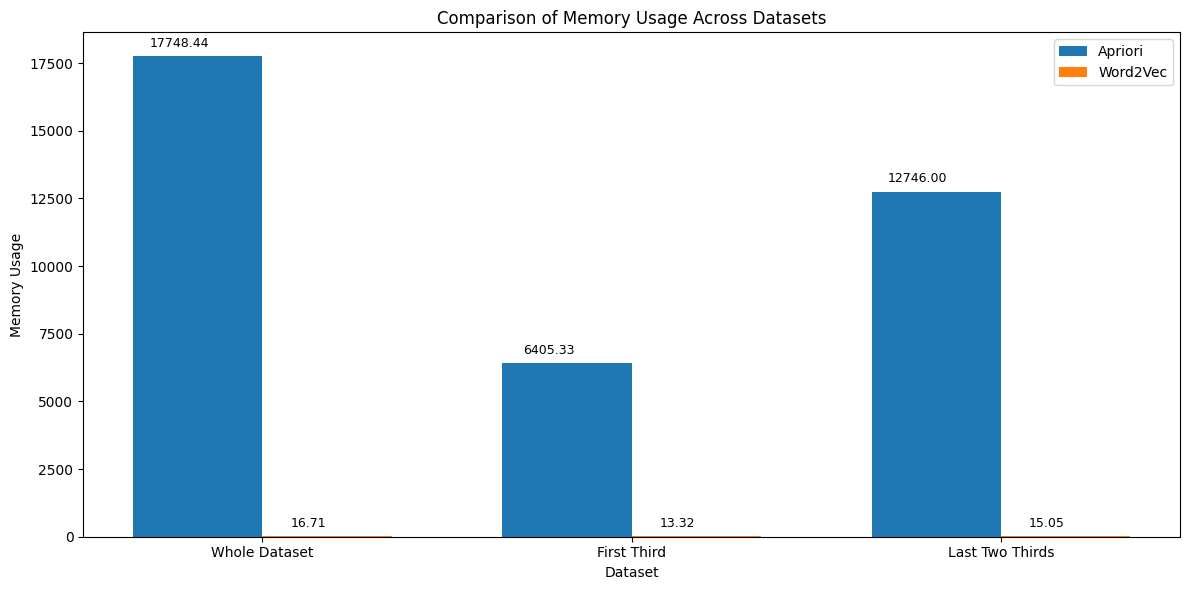

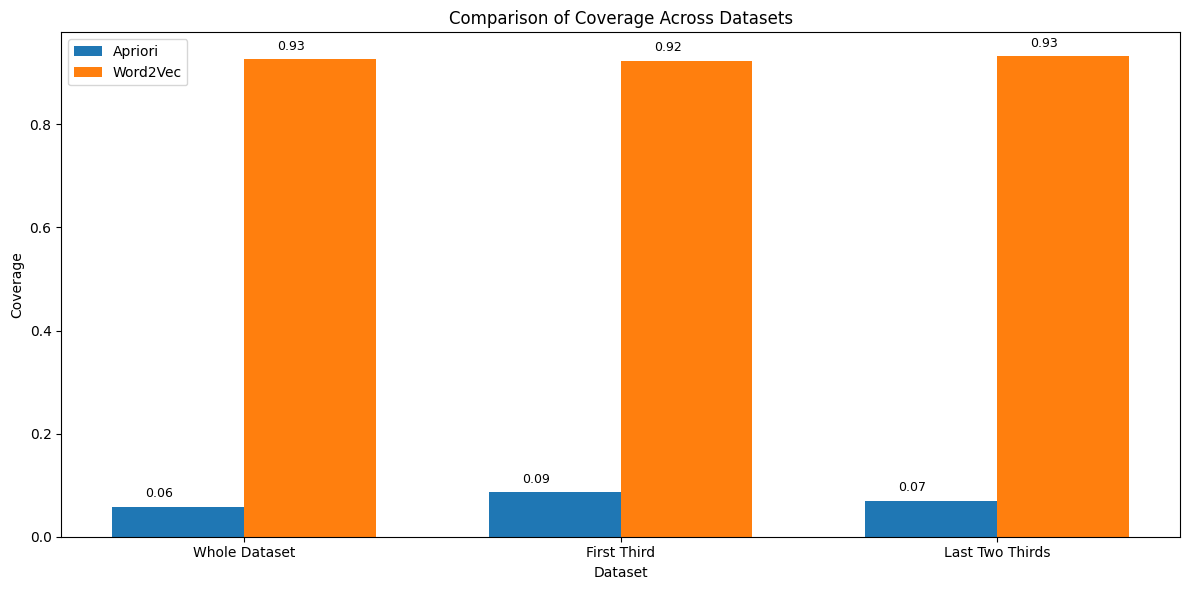

Combined comparison visualizations and metrics saved.

All evaluations completed and results saved.


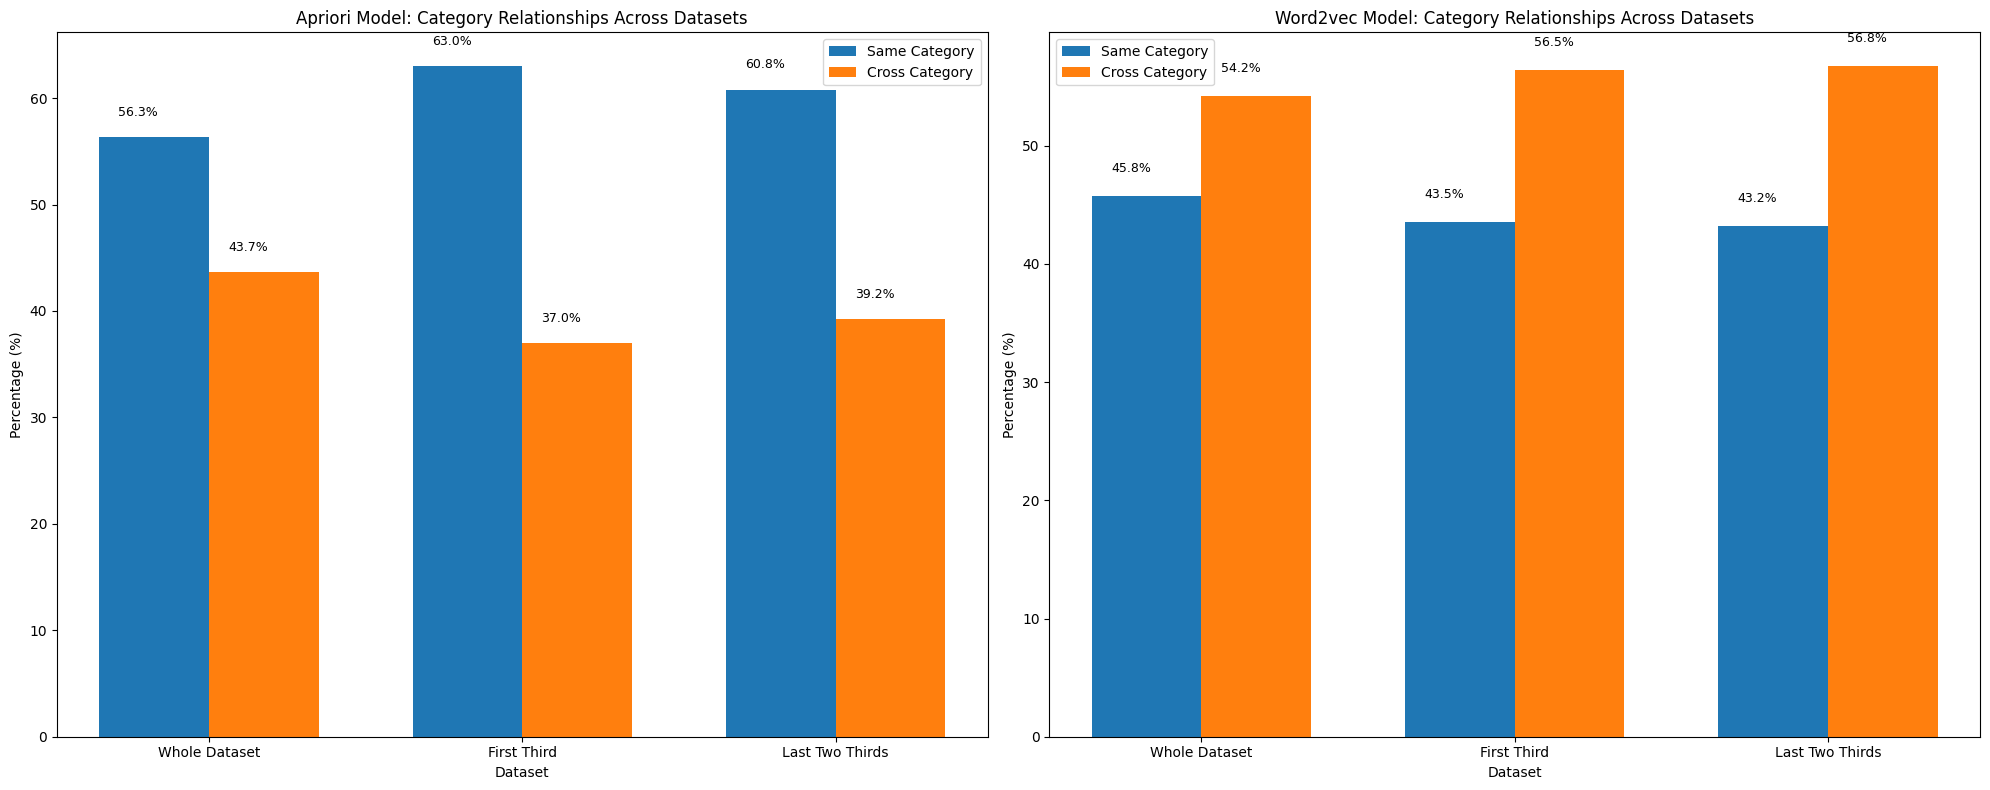

Combined category relationship comparisons and metrics saved.

All category relationship comparisons completed and results saved.


<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

In [22]:

# ===== COMBINED VISUALIZATION =====
# comparing key metrics across all three datasets
def create_combined_comparison():
    metrics = ['execution_time', 'memory_usage', 'coverage']
    datasets = ['whole_dataset', 'first_third', 'last_two_thirds']
    
    for metric in metrics:
        # setting up figure
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # preparing data
        apriori_values = [
            evaluator_whole.metrics['apriori'][metric],
            evaluator_first_third.metrics['apriori'][metric],
            evaluator_last_two_thirds.metrics['apriori'][metric]
        ]
        
        word2vec_values = [
            evaluator_whole.metrics['word2vec'][metric],
            evaluator_first_third.metrics['word2vec'][metric],
            evaluator_last_two_thirds.metrics['word2vec'][metric]
        ]
        
        # setting bar positions
        bar_width = 0.35
        index = np.arange(len(datasets))
        
        # creating bars
        bar1 = ax.bar(index, apriori_values, bar_width, label='Apriori')
        bar2 = ax.bar(index + bar_width, word2vec_values, bar_width, label='Word2Vec')
        
        # adding labels and title
        ax.set_xlabel('Dataset')
        ax.set_ylabel(f'{metric.replace("_", " ").title()}')
        ax.set_title(f'Comparison of {metric.replace("_", " ").title()} Across Datasets')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels([d.replace("_", " ").title() for d in datasets])
        ax.legend()
        
        # adiing values on top of bars
        for i, v in enumerate(apriori_values):
            ax.text(i - 0.05, v + (max(apriori_values + word2vec_values) * 0.02), 
                    f'{v:.2f}', ha='center', fontsize=9)
                    
        for i, v in enumerate(word2vec_values):
            ax.text(i + bar_width - 0.05, v + (max(apriori_values + word2vec_values) * 0.02), 
                    f'{v:.2f}', ha='center', fontsize=9)
        
        plt.tight_layout()
        plt.savefig(os.path.join(path_results, f'combined_{metric}_comparison.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
    #  creating a table with all metrics
    combined_metrics = pd.DataFrame({
        'Metric': ['Execution Time (s)', 'Memory Usage (MB)', 'Coverage'],
        'Whole_Apriori': [evaluator_whole.metrics['apriori']['execution_time'], 
                        evaluator_whole.metrics['apriori']['memory_usage'], 
                        evaluator_whole.metrics['apriori']['coverage']],
        'Whole_Word2Vec': [evaluator_whole.metrics['word2vec']['execution_time'], 
                            evaluator_whole.metrics['word2vec']['memory_usage'], 
                            evaluator_whole.metrics['word2vec']['coverage']],
                            'First_Third_Apriori': [evaluator_first_third.metrics['apriori']['execution_time'], 
                                evaluator_first_third.metrics['apriori']['memory_usage'], 
                                evaluator_first_third.metrics['apriori']['coverage']],
        'First_Third_Word2Vec': [evaluator_first_third.metrics['word2vec']['execution_time'], 
                                evaluator_first_third.metrics['word2vec']['memory_usage'], 
                                evaluator_first_third.metrics['word2vec']['coverage']],
        'Last_Two_Thirds_Apriori': [evaluator_last_two_thirds.metrics['apriori']['execution_time'], 
                                    evaluator_last_two_thirds.metrics['apriori']['memory_usage'], 
                                    evaluator_last_two_thirds.metrics['apriori']['coverage']],
        'Last_Two_Thirds_Word2Vec': [evaluator_last_two_thirds.metrics['word2vec']['execution_time'], 
                                    evaluator_last_two_thirds.metrics['word2vec']['memory_usage'], 
                                    evaluator_last_two_thirds.metrics['word2vec']['coverage']]
    })
    
    # saving combined metrics
    combined_metrics.to_csv(os.path.join(path_results, 'combined_metrics_comparison.csv'), index=False)
    
    # creating a readable HTML table for better visualization
    html_table = combined_metrics.to_html(index=False)
    with open(os.path.join(path_results, 'combined_metrics_comparison.html'), 'w') as f:
        f.write("""
        <html>
        <head>
            <style>
                table { border-collapse: collapse; width: 100%; }
                th, td { text-align: center; padding: 8px; border: 1px solid #ddd; }
                th { background-color: #f2f2f2; }
                tr:nth-child(even) { background-color: #f9f9f9; }
            </style>
        </head>
        <body>
        <h2>Combined Metrics Comparison</h2>
        """)
        f.write(html_table)
        f.write("</body></html>")
    
    print("Combined comparison visualizations and metrics saved.")

# importing numpy for the bar positions
import numpy as np

# creating combined comparison
create_combined_comparison()

print("\nAll evaluations completed and results saved.")



def create_combined_category_comparison():
    """
    Create visualizations and tables comparing cross-category relationships across all data partitions.
    """
    datasets = ['whole_dataset', 'first_third', 'last_two_thirds']
    models = ['apriori', 'word2vec']
    
    # collecting category analysis results from all evaluators
    whole_analysis = evaluator_whole.analyze_category_relationships()
    first_third_analysis = evaluator_first_third.analyze_category_relationships()
    last_two_thirds_analysis = evaluator_last_two_thirds.analyze_category_relationships()
    
    # creating side-by-side comparison of same vs cross-category percentages
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    for i, model in enumerate(models):
        ax = axes[i]
        
  
        same_category_values = [
            whole_analysis[model]['same_category_percentage'],
            first_third_analysis[model]['same_category_percentage'],
            last_two_thirds_analysis[model]['same_category_percentage']
        ]
        
        cross_category_values = [
            whole_analysis[model]['cross_category_percentage'],
            first_third_analysis[model]['cross_category_percentage'],
            last_two_thirds_analysis[model]['cross_category_percentage']
        ]
        
       
        bar_width = 0.35
        index = np.arange(len(datasets))
        
      
        bar1 = ax.bar(index, same_category_values, bar_width, label='Same Category')
        bar2 = ax.bar(index + bar_width, cross_category_values, bar_width, label='Cross Category')
        
       
        ax.set_xlabel('Dataset')
        ax.set_ylabel('Percentage (%)')
        ax.set_title(f'{model.capitalize()} Model: Category Relationships Across Datasets')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels([d.replace("_", " ").title() for d in datasets])
        ax.legend()
        
     
        for j, v in enumerate(same_category_values):
            ax.text(j - 0.05, v + 2, f'{v:.1f}%', ha='center', fontsize=9)
                    
        for j, v in enumerate(cross_category_values):
            ax.text(j + bar_width - 0.05, v + 2, f'{v:.1f}%', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(path_results, 'combined_category_relationships.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
  
    combined_category_metrics = pd.DataFrame({
        'Metric': ['Same Category %', 'Cross Category %'],
        'Whole_Apriori': [
            whole_analysis['apriori']['same_category_percentage'],
            whole_analysis['apriori']['cross_category_percentage']
        ],
        'Whole_Word2Vec': [
            whole_analysis['word2vec']['same_category_percentage'],
            whole_analysis['word2vec']['cross_category_percentage']
        ],
        'First_Third_Apriori': [
            first_third_analysis['apriori']['same_category_percentage'],
            first_third_analysis['apriori']['cross_category_percentage']
        ],
        'First_Third_Word2Vec': [
            first_third_analysis['word2vec']['same_category_percentage'],
            first_third_analysis['word2vec']['cross_category_percentage']
        ],
        'Last_Two_Thirds_Apriori': [
            last_two_thirds_analysis['apriori']['same_category_percentage'],
            last_two_thirds_analysis['apriori']['cross_category_percentage']
        ],
        'Last_Two_Thirds_Word2Vec': [
            last_two_thirds_analysis['word2vec']['same_category_percentage'],
            last_two_thirds_analysis['word2vec']['cross_category_percentage']
        ]
    })
    
   
    combined_category_metrics.to_csv(os.path.join(path_results, 'combined_category_metrics.csv'), index=False)
    
  
    html_table = combined_category_metrics.to_html(index=False)
    with open(os.path.join(path_results, 'combined_category_metrics.html'), 'w') as f:
        f.write("""
        <html>
        <head>
            <style>
                table { border-collapse: collapse; width: 100%; }
                th, td { text-align: center; padding: 8px; border: 1px solid #ddd; }
                th { background-color: #f2f2f2; }
                tr:nth-child(even) { background-color: #f9f9f9; }
            </style>
        </head>
        <body>
        <h2>Combined Category Relationships Comparison</h2>
        """)
        f.write(html_table)
        f.write("</body></html>")
    
    
    compare_top_category_pairs(whole_analysis, first_third_analysis, last_two_thirds_analysis)
    
    print("Combined category relationship comparisons and metrics saved.")

def compare_top_category_pairs(whole_analysis, first_third_analysis, last_two_thirds_analysis):
    """
    Compare top category pairs across different datasets.
    """
    models = ['apriori', 'word2vec']
    datasets = ['Whole Dataset', 'First Third', 'Last Two Thirds']
    analyses = [whole_analysis, first_third_analysis, last_two_thirds_analysis]
    
    for model in models:
    
        plt.figure(figsize=(15, 12))
    
        all_top_pairs = []
        
        for i, analysis in enumerate(analyses):
            if 'top_category_combinations' in analysis[model]:
                top_pairs = analysis[model]['top_category_combinations'].head(5)
                
       
                for _, row in top_pairs.iterrows():
                    pair_name = f"{row['Original Product category']} → {row['Complementary Product category']}"
                    all_top_pairs.append((pair_name, row['frequency'], datasets[i]))
        
     
        unique_pairs = list(set([pair[0] for pair in all_top_pairs]))
 
        pair_frequencies = {dataset: {pair: 0 for pair in unique_pairs} for dataset in datasets}
        

        for pair_name, freq, dataset in all_top_pairs:
            pair_frequencies[dataset][pair_name] = freq
        
   
        df_pairs = pd.DataFrame(pair_frequencies)
        
    
        df_pairs['Total'] = df_pairs.sum(axis=1)
        df_pairs = df_pairs.sort_values('Total', ascending=False).head(10)
        df_pairs = df_pairs.drop('Total', axis=1)
        
      
        ax = df_pairs.plot(kind='bar', figsize=(15, 8))
        
        plt.title(f'Top Category Pairs Comparison - {model.capitalize()} Model', fontsize=16)
        plt.xlabel('Category Pair', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
     
        plt.savefig(os.path.join(path_results, f'{model}_top_category_pairs_comparison.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        
       
        df_pairs.to_csv(os.path.join(path_results, f'{model}_top_category_pairs_comparison.csv'))


import numpy as np


create_combined_category_comparison()

print("\nAll category relationship comparisons completed and results saved.")